# <font color=#295172>Part 3 of 4 - Model Training and Analysis</font>

#### <font color=#6185a0>| Final Capstone Project for the Diploma Program in Data Science | BrainStation Vancouver |</font>

<font color=#6185a0>| Arash Tavassoli | May-June 2019 |</font>

---
This is the third notebook in a series of four:
* **Part 1 - Exploratory Data Analysis**

* **Part 2 - Data Preprocessing**

* **<font color=#cc6900>Part 3 - Model Training and Analysis</font>**

* **Part 4 - Real-Time Facial Expression Recognition**

### What to expect in this notebook:

1. A brief intoroduction to the approach taken in compiling and training the models
2. A set of helper functions and an Excel spreadsheet that will be used for compiling and training the models
3. Training of one model for each of the 3 and 5-expression classifiers
3. Model performance analysis and comparison to human accuracies from Notebook 1

---
## 1. Convolutional Neural Networks:
Convolutional Neural Networks (CNN) are currently considered as one of the top choices for any image classification problem, primarily because they are able to pick up on patterns in small parts of an image. However, this deep learning approach shows its true power only when it is presented with large enough data at the training stage. It is also considered as a computationally expensive Machine Learning system, given the large number of trainable parameters, specially in larger (deeper) network architectures.

In this project we will use Python's high-level neural networks API, Keras (using TensorFlow backend) to build and tune a Convolutional Neural Network on the images that we processed in the previous notebooks.


## 2. The Approach:

Considering the large number of hyperparameters that can be tuned for a Convolutional Neural Network, the approach for this project is to build a set of helper functions that, given a model number, can read the hyperparameters for each convolutional (CONV) and fully connected (FC) layers, as well as the optimization parameters, from an Excel sheet that is saved as `Model Params.xlsx`. The functions will then compile the sequential model and save the trained model, the training history and some accuracy metrics on a new folder (with the same model number), and also update the Excel sheet with the training time, training accuracy and validation accuracy:

<img src="Data/Images/Notebook3.png" width="900" />

As you can see, training will focus on a model with 3 and anoher model with 5 classes of facial expressions.

### 1.1. The Excel Sheet with Pre-Defined Hyperparameters

The `Model Params.xlsx` is saved in the same folder as the current notebook and hosts the values for the following hyperparameters that will be used during model training:

- **For each CONV layer:**
    - Number of filters (int)
    - Filter size (int)
    - Filter strides (int)
    - Filter padding type ('same' or 'valid')
    - Activation function ('relu', 'sigmoid', 'tanh')
    - Kernel Initializer ('Xavier')
    - L2 regularization weight (float)
    - Pooling type ('Average' or 'Max')
    - Pooling filter size (int)
    - Pooling filter strides (int)
    - Pooling filter padding type ('same' or 'valid') 
    - Dropout rate (float between 0 and 1)


- **For each FC layer:**
    - Number of filters (int)
    - Activation function ('relu', 'sigmoid', 'tanh')
    - L2 regularization weight (float)
    - Dropout rate (float between 0 and 1)
    
    
- **Other parameters:**
    - Model number (int)
    - Number of classes (3 or 5)
    - Number of epochs (int)
    - Batch size (int)
    - Optimizer type ('Adam')
    - Learning rate (float)
    - Image input size (100x100 for this project)
    
<img src="Data/Images/Excel Sheet.png" style="width: 1000px;"/>

Let's start by importing the required libraries:

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, SpatialDropout2D, AveragePooling2D, BatchNormalization, Activation
from keras import regularizers
from keras.utils import plot_model
from keras import models

from google.colab import drive
from IPython.display import clear_output
import json
import time
import os

Using TensorFlow backend.


The entire model training process has been done on Google Colab (to use GPUs), therefore the following root directory is specific to my personal Google Drive where the notebook was saved:

In [0]:
# This root_dir is used after mounting the Google Drive on Google Colab environment
root_dir = '/gdrive/My Drive/Colab Notebooks/BrainStation Capstone - Colab'

In [4]:
# Mount Google Drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


Let's load the Excel sheet, with hyperparameters already saved on it:

In [5]:
# Loading the Excel sheet with pre-defined hyperparameters:
params_sheet = pd.read_excel(root_dir + '/Model Params.xlsx').drop(['Unnamed: 0'],axis=1)

# Optional preview of the parameters for a selected model:
model_number = 9
display(params_sheet[params_sheet['model'] == model_number])

,model,layer,type,size,filter_size,filter_s,filter_p,activ_fun,kernel_init,L2_reg,pool_type,pool_size,pool_s,pool_p,dropout_rate,num_classes,num_epochs,batch_size,optimizer,learning_rate,input_pixel,train_time,train_acc,val_acc
95,9,1,CONV,64,3,1,same,relu,Xavier,0.0001,None,-,-,-,0.2,3,30,50,Adam,5e-05,100,208,86.12,90.23
96,9,2,CONV,64,3,2,same,relu,Xavier,0.0001,Max,3,1,valid,0.2,-,-,-,-,-,-,-,-,-
97,9,3,CONV,128,3,1,same,relu,Xavier,0.0001,None,-,-,-,0.3,-,-,-,-,-,-,-,-,-
98,9,4,CONV,128,3,2,same,relu,Xavier,0.0001,Max,3,1,valid,0.3,-,-,-,-,-,-,-,-,-
99,9,5,CONV,256,3,1,same,relu,Xavier,0.0001,None,-,-,-,0.3,-,-,-,-,-,-,-,-,-
100,9,6,CONV,256,3,2,same,relu,Xavier,0.0001,Max,3,1,valid,0.4,-,-,-,-,-,-,-,-,-
101,9,7,FC,128,-,-,-,relu,-,0.0001,-,-,-,-,0.2,-,-,-,-,-,-,-,-,-
102,9,8,FC,64,-,-,-,relu,-,0.0001,-,-,-,-,0.2,-,-,-,-,-,-,-,-,-


### 1.2. Helper Functions

We can now start building the helper functions that will load the data, compile the model and visualize the performance:

#### 1.2.1. Model Compiler

Given a model number (from available models on the Excel sheet), this function reads the hyperparameters from the Excel sheet and compile a sequantial model in Keras:

In [0]:
# A function to construct the network based on parameters saved on the excel sheet:
def model_compiler(params_sheet, model_number):
    
    # Filtering the params_sheet to parameters specific to one given model number
    param_df = params_sheet[params_sheet['model'] == model_number].reset_index()
    
    # Loding hyperparams
    num_epochs = int(param_df.loc[0, 'num_epochs'])
    mini_batch_size = int(param_df.loc[0, 'batch_size'])
    num_classes = int(param_df.loc[0, 'num_classes'])
    optimizer_type = param_df.loc[0, 'optimizer']
    learning_rate = param_df.loc[0, 'learning_rate']
    input_pixel = param_df.loc[0, 'input_pixel']
    
    # Starting to construct the sequential model
    model = Sequential()
    
    # The CONV layers
    for i in param_df[param_df['type'] == 'CONV'].index:
    
        if param_df.loc[i, 'kernel_init'] == 'Xavier':
            initializer = keras.initializers.glorot_normal(seed = 1)
        else:
            print('Initializer Undefined')
            break
        
        # For layer 1 we need to define the input_shape
        if i == 0:    
            model.add(Conv2D(filters = param_df.loc[i, 'size'], 
                             kernel_size = param_df.loc[i, 'filter_size'], 
                             strides = (param_df.loc[i, 'filter_s'], param_df.loc[i, 'filter_s']), 
                             padding = param_df.loc[i, 'filter_p'], 
                             kernel_initializer = initializer, 
                             kernel_regularizer = regularizers.l2(param_df.loc[i, 'L2_reg']),
                             input_shape = (input_pixel, input_pixel, 1)))
        else:
            model.add(Conv2D(filters = param_df.loc[i, 'size'], 
                             kernel_size = param_df.loc[i, 'filter_size'], 
                             strides = (param_df.loc[i, 'filter_s'], param_df.loc[i, 'filter_s']), 
                             padding = param_df.loc[i, 'filter_p'], 
                             kernel_initializer = initializer, 
                             kernel_regularizer = regularizers.l2(param_df.loc[i, 'L2_reg'])))
        
        # Using batch normalization
        model.add(BatchNormalization())
        
        model.add(Activation(param_df.loc[i, 'activ_fun']))
        
        # Add pooling
        if param_df.loc[i, 'pool_type'] == 'Max':
            model.add(MaxPooling2D(pool_size = (param_df.loc[i, 'pool_size'], param_df.loc[i, 'pool_size']), 
                                   strides = (param_df.loc[i, 'pool_s'], param_df.loc[i, 'pool_s']), 
                                   padding = param_df.loc[i, 'pool_p']))
        if param_df.loc[i, 'pool_type'] == 'Average':
            model.add(AveragePooling2D(pool_size = (param_df.loc[i, 'pool_size'], param_df.loc[i, 'pool_size']), 
                                       strides = (param_df.loc[i, 'pool_s'], param_df.loc[i, 'pool_s']), 
                                       padding = param_df.loc[i, 'pool_p']))
        model.add(SpatialDropout2D(rate = param_df.loc[i, 'dropout_rate']))
    
    # Flattening
    model.add(Flatten())
    
    # The fully connected layers
    for i in param_df[param_df['type'] == 'FC'].index:
        model.add(Dense(units = param_df.loc[i, 'size'], 
                        activation = param_df.loc[i, 'activ_fun']))

        model.add(Dropout(rate = param_df.loc[i, 'dropout_rate']))
    
    # SoftMax layer as the output
    model.add(Dense(units = num_classes, activation='softmax'))

    # Compiling the model
    if optimizer_type == 'Adam':
        model.compile(optimizer = keras.optimizers.Adam(lr = learning_rate, epsilon = 1e-8),
                      loss = 'categorical_crossentropy', 
                  metrics = ['accuracy'])
    return model, num_epochs, mini_batch_size, input_pixel

#### 1.2.2. Performance Visualizer
Given the `history` output from the trained model, this function prints out the training, validation and test accuracies, as well as the accuracy plots and confusion matrix for the trained model:

In [0]:
# A function to visualize the accuracies, confusion matrix and classification report:
def summary_visualizer(history, path, X_test, y_test, params_sheet, model_number):    
    
    param_df = params_sheet[params_sheet['model'] == model_number].reset_index()
    num_classes = int(param_df.loc[0, 'num_classes'])
    
    # Selecting the right expression names based on num of classes
    if num_classes == 3:
        expression_names = ['Happy', 'Sad', 'Surprised']
    if num_classes == 5:
        expression_names = ['Neutral','Happy', 'Sad', 'Surprised','Angry']
    
    clear_output(wait = True)
    
    # Defining true and predicted labels
    y_true = np.argmax(y_test, axis = 1)
    y_pred = np.argmax(model.predict(X_test), axis = 1)
    
    print(f"Training accuracy:\t({(history.history['acc'][-1]*100):.2f}%, {(max(history.history['acc'])*100):.2f}%) (last epoch, highest)")
    print(f"Validation accuracy:\t({(history.history['val_acc'][-1]*100):.2f}%, {(max(history.history['val_acc'])*100):.2f}%) (last epoch, highest)")
    print(f"Test accuracy:\t\t({(sum(y_true == y_pred) / len(y_true) * 100):.2f}%)\n")

    # Constructing the confusion matrix and calculating percentage of correct and incorrect predictions
    conf_matrix = confusion_matrix(y_true = y_true, y_pred = y_pred)
    conf_matrix_df = pd.DataFrame(data = conf_matrix, columns = expression_names, index = expression_names)
    conf_matrix_percent = round(conf_matrix_df/conf_matrix_df.sum(axis = 1)*100, 2)
    
    print('Model accuracy and loss function:\n')

    plt.figure(figsize = (14,4))
    gridspec.GridSpec(1,2)

    # Summarize history for accuracy
    plt.subplot2grid((1,2), (0,0))
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='lower right')

    # Summarize history for loss
    plt.subplot2grid((1,2), (0,1))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right');
    plt.savefig(path + os.sep + "Accuracy_Plot.png")
    plt.show();

    print('The confusion matrix:\n')

    plt.figure(figsize = (12,4))
    gridspec.GridSpec(1,2)

    # Plotting the confusion matrix
    plt.subplot2grid((1,2), (0,0))
    sns.heatmap(conf_matrix_df, annot=True, cmap = 'Blues', fmt='g', linewidths = .8)
    plt.ylabel('True label', labelpad = 5)
    plt.xlabel('Predicted label', labelpad = 20)
    plt.title('Confusion matrix')
    plt.yticks(rotation=0);

    # Plotting the Percentage of correct and incorrect predictions for each class
    plt.subplot2grid((1,2), (0,1))
    sns.heatmap(conf_matrix_percent, annot=True, cmap = 'Blues', fmt='g', linewidths = .8)
    plt.ylabel('True label', labelpad = 5)
    plt.xlabel('Predicted label', labelpad = 20)
    plt.title('Percentage of correct/incorrect predictions for each class\n(Predicted / Total in True Class)', fontsize = 10)
    plt.yticks(rotation=0);

    plt.tight_layout(w_pad=8)
    plt.savefig(path + os.sep + "Confusion_matrix.png")
    plt.show()
    
    # Printing the classification report
    print('\nThe classification report:\n')
    print(classification_report(y_true = y_true, 
                                y_pred = y_pred, 
                                target_names = expression_names))

#### 1.2.3. Data Loader
This function simply loads the `.npy` files that we exported in the previous notebook, based on the number of classes that is defined on the Excel sheet (for a given model number):

In [0]:
# A function to load the appropriate data files:
def data_loader(params_sheet, model_number):
    param_df = params_sheet[params_sheet['model'] == model_number].reset_index()
    num_classes = int(param_df.loc[0, 'num_classes'])
    
    if num_classes == 3:
        X_train = np.load(root_dir + '/Data/3 Expressions/X_train_3classes.npy')
        X_test = np.load(root_dir + '/Data/3 Expressions/X_test_3classes.npy')
        X_val = np.load(root_dir + '/Data/3 Expressions/X_val_3classes.npy')
        y_train = np.load(root_dir + '/Data/3 Expressions/y_train_3classes.npy')
        y_test = np.load(root_dir + '/Data/3 Expressions/y_test_3classes.npy')
        y_val = np.load(root_dir + '/Data/3 Expressions/y_val_3classes.npy')

    elif num_classes == 5:
        X_train = np.load(root_dir + '/Data/5 Expressions/X_train_5classes.npy')
        X_test = np.load(root_dir + '/Data/5 Expressions/X_test_5classes.npy')
        X_val = np.load(root_dir + '/Data/5 Expressions/X_val_5classes.npy')
        y_train = np.load(root_dir + '/Data/5 Expressions/y_train_5classes.npy')
        y_test = np.load(root_dir + '/Data/5 Expressions/y_test_5classes.npy')
        y_val = np.load(root_dir + '/Data/5 Expressions/y_val_5classes.npy')
        
    print(f'X_train shape:\t{X_train.shape}')
    print(f'y_train shape:\t{y_train.shape}')
    print(f'X_val shape:\t{X_val.shape}')
    print(f'y_val shape:\t{y_val.shape}')
    print(f'X_test shape:\t{X_test.shape}')
    print(f'y_test shape:\t{y_test.shape}')

    return X_train, X_test, X_val, y_train, y_test, y_val

### 1.3. Model Training

With the helper functions defined, we can now train the CNNs, first with 3 expressions (Happy, Sad, Surprised) and then with 5 expressions (Happy, Sad, Surprised, Angry and Neutral):

#### 1.3.1. Model with 3-Classes (Happy, Sad, Surprised)

For 3 classe, training is done on different combinations of hyperparameters and the best performing model is found to be Model # 9 on the Excel sheet with the following key parameters and performance metrics:

<img src="Data/Images/3class_summary.png" style="width: 900px;"/>



In [0]:
# Loading the data (3 classes):
model_number = 9   # See the excel sheet for list of other models
X_train, X_test, X_val, y_train, y_test, y_val = data_loader(params_sheet, model_number)

In [0]:
# Compiling the model (3 classes):
model, num_epochs, mini_batch_size, input_pixel = model_compiler(params_sheet, model_number)

Training accuracy:	(86.12%, 86.12%) (last epoch, highest)
Validation accuracy:	(90.15%, 90.23%) (last epoch, highest)
Test accuracy:		(90.19%)

Model accuracy and loss function:



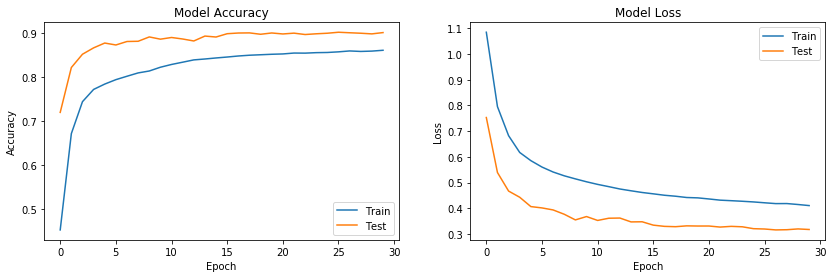

The confusion matrix:



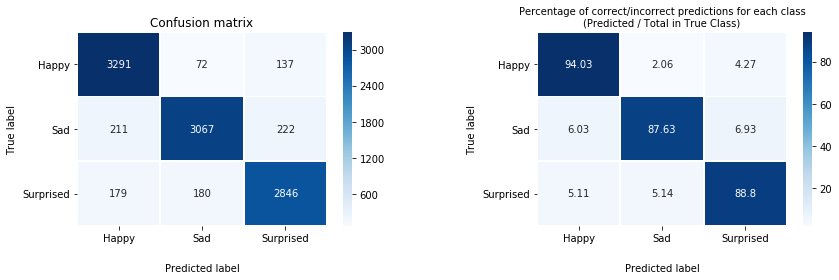


The classification report:

              precision    recall  f1-score   support

     Neutral       0.89      0.94      0.92      3500
       Happy       0.92      0.88      0.90      3500
         Sad       0.89      0.89      0.89      3205

    accuracy                           0.90     10205
   macro avg       0.90      0.90      0.90     10205
weighted avg       0.90      0.90      0.90     10205



In [0]:
# Training the model (3 classes):
start_time = time.time()
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), 
                    batch_size = mini_batch_size, 
                    epochs = num_epochs, verbose = 2)
end_time = time.time()

# Creating a new directory to save model and history:
path = root_dir + '/Models/' + str(model_number)
if not os.path.exists(path):
    os.mkdir(path)

model.save(path + os.sep + 'model.h5')                                         # Saving the model
json.dump(history.history, open(path + os.sep + 'Model_history.json', 'w'))    # Saving the history
plot_model(model, to_file=path + os.sep + 'Model.png', show_shapes = True)     # Saving the model visualization

# Updating the Excel sheet:
row_index = params_sheet[params_sheet['model'] == model_number].index[0]
params_sheet.loc[row_index, 'train_acc'] = round(max(history.history['acc'])*100, 2)
params_sheet.loc[row_index, 'val_acc'] = round(max(history.history['val_acc'])*100, 2)
params_sheet.loc[row_index, 'train_time'] = round((end_time - start_time)/60)
params_sheet.to_excel(root_dir + '/Model Params.xlsx')

# Plotting training history:
summary_visualizer(history, path, X_test, y_test, params_sheet, model_number)

#### 1.3.2. Model with 5-Classes (Happy, Sad, Surprised, Angry and Neutral)

Similarly, for 5 classes, training is done on different combinations of hyperparameters and the best performing model is found to be Model # 11 on the Excel sheet with the following key parameters and performance metrics:

<img src="Data/Images/5class_summary.png" style="width: 900px;"/>

In [0]:
# Loading the data (5 Classes):
model_number = 11   # See the excel sheet for list of other models
X_train, X_test, X_val, y_train, y_test, y_val = data_loader(params_sheet, model_number)

In [0]:
# Compiling the model (5 Classes):
model, num_epochs, mini_batch_size, input_pixel = model_compiler(params_sheet, model_number)

Training accuracy:	(71.24%, 71.24%) (last epoch, highest)
Validation accuracy:	(75.69%, 75.96%) (last epoch, highest)
Test accuracy:		(75.66%)

Model accuracy and loss function:



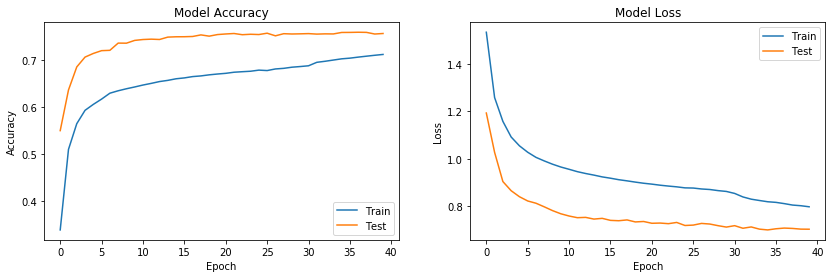

The confusion matrix:



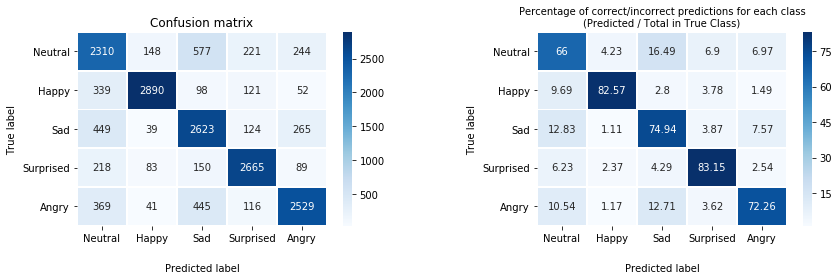


The classification report:

              precision    recall  f1-score   support

     Neutral       0.63      0.66      0.64      3500
       Happy       0.90      0.83      0.86      3500
         Sad       0.67      0.75      0.71      3500
   Surprised       0.82      0.83      0.83      3205
       Angry       0.80      0.72      0.76      3500

    accuracy                           0.76     17205
   macro avg       0.76      0.76      0.76     17205
weighted avg       0.76      0.76      0.76     17205



In [0]:
# Training the model (5 Classes):
start_time = time.time()
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), 
                    batch_size = mini_batch_size, 
                    epochs = num_epochs, verbose = 2)
end_time = time.time()

# Creating a new directory to save model and history files:
path = root_dir + '/Models/' + str(model_number)
if not os.path.exists(path):
    os.mkdir(path)

model.save(path + os.sep + 'model.h5')                                         # Saving the model
json.dump(history.history, open(path + os.sep + 'Model_history.json', 'w'))    # Saving the history
plot_model(model, to_file=path + os.sep + 'Model.png', show_shapes = True)     # Saving the model visualization

# Updating the Excel sheet:
row_index = params_sheet[params_sheet['model'] == model_number].index[0]
params_sheet.loc[row_index, 'train_acc'] = round(max(history.history['acc'])*100, 2)
params_sheet.loc[row_index, 'val_acc'] = round(max(history.history['val_acc'])*100, 2)
params_sheet.loc[row_index, 'train_time'] = round((end_time - start_time)/60)
params_sheet.to_excel(root_dir + '/Model Params.xlsx')

# Plotting training history:
summary_visualizer(history, path, X_test, y_test, params_sheet, model_number)

One interesting observation above is that for both 3-class and 5-class models, the validation accuracy (test on the plot) is always higher than the training accuracy, although a reversed trend is expected in most model training processes (similar observation with the loss values). This is an expected trend from the model training process on Keras for the following two reasons (source: [Keras FAQ](https://keras.io/getting-started/faq/#why-is-the-training-loss-much-higher-than-the-testing-loss)):

1. Regularization mechanisms, such as Dropout and L1/L2 weight regularization, are turned off at testing/validation time.

2. The training loss is the average of the losses over each batch of training data. Because the model is changing over time, the loss over the first batches of an epoch is generally higher than over the last batches. On the other hand, the testing/validation loss for an epoch is computed using the model as it is at the end of the epoch, resulting in a lower loss.

### 1.4. Performance Analysis:

As the last section of this notebook, we look back at the human accuracies that we defined in the fist notebook (EDA) and compare our model accuracies with the accuracies that we got from hand-labelling a set of 1000 sample images for 5 classes and 600 sample images for 3 classes:

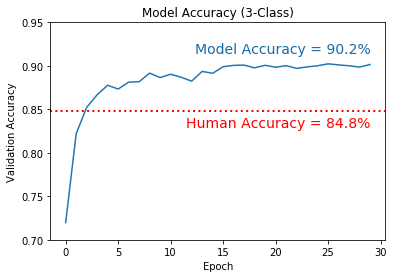

In [0]:
# Loading the data for 3 Classes:
model_number = 9
with open(root_dir + '/Models/9/Model_history.json') as json_file:  
    history = json.load(json_file)
    
plt.plot(history['val_acc'])
plt.title('Model Accuracy (3-Class)')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.axhline(0.8483, color = 'red', ls = ':', linewidth=2)
plt.text(11.5, 0.83, 'Human Accuracy = 84.8%', color = 'red', size = 14)
plt.text(12.3, 0.915, 'Model Accuracy = 90.2%', color = '#186aa3', size = 14)
plt.ylim((0.7, 0.95));

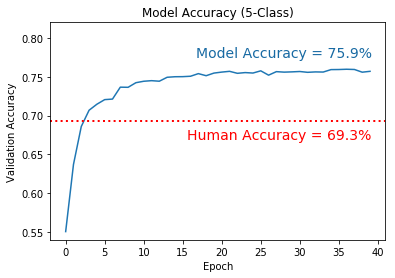

In [0]:
# Loading the data for 5 Classes:
model_number = 11
with open(root_dir + '/Models/11/Model_history.json') as json_file:  
    history = json.load(json_file)
    
plt.plot(history['val_acc'])
plt.title('Model Accuracy (5-Class)')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.axhline(0.6930, color = 'red', ls = ':', linewidth=2)
plt.text(16.68, 0.775, 'Model Accuracy = 75.9%', color = '#186aa3', size = 14)
plt.text(15.5, 0.67, 'Human Accuracy = 69.3%', color = 'red', size = 14)
plt.ylim((0.54, 0.82));

Although the validation accurcies of 90.2% and 75.9% for the 3-class and 5-class models may not sound super impressive, it is shown that the models are still performing superior to what a human can do on the same set of data. This is once again explained by the fact that many images in this dataset are difficult to classify, even for a human mind.

We can now use the saved models in the next notebook to build a real-time facial expression recognizer!